In [6]:
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Load organAMNIST dataset
data_flag = 'organamnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))  # Repeat the single channel 3 times
])

train_dataset = DataClass(split='train', download=download, transform=transform)
val_dataset = DataClass(split='val', download=download, transform=transform)
test_dataset = DataClass(split='test', download=download, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=128, shuffle=False, drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)


In [4]:
from torch.utils.data import ConcatDataset

# Combine train_dataset and val_dataset
combined_train_dataset = ConcatDataset([train_dataset, val_dataset])

# Create a new DataLoader for the combined dataset
combined_train_loader = DataLoader(dataset=combined_train_dataset, batch_size=128, shuffle=True, drop_last=True)

In [5]:
from sklearn.model_selection import StratifiedKFold

# Create stratified K-fold cross-validator
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Get the labels for stratification
labels = [label for _, label in combined_train_dataset]

# Create a list to store the new dataloaders
train_loaders = []
val_loaders = []

for train_index, val_index in skf.split(np.zeros(len(labels)), labels):
    train_subset = torch.utils.data.Subset(combined_train_dataset, train_index)
    val_subset = torch.utils.data.Subset(combined_train_dataset, val_index)
    
    train_loader = DataLoader(dataset=train_subset, batch_size=128, shuffle=True, drop_last=True)
    val_loader = DataLoader(dataset=val_subset, batch_size=128, shuffle=False, drop_last=True)
    
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

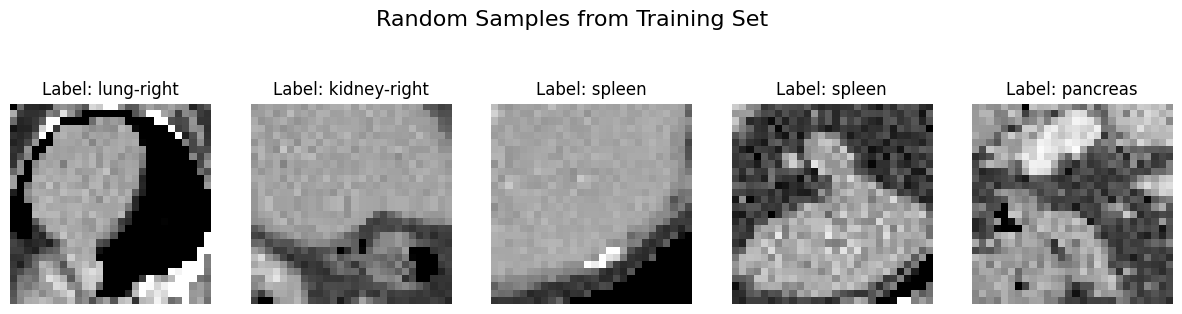

In [7]:
import random

# Function to display images
def show_images(images, labels, title=None):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 4))
    if title:
        fig.suptitle(title, fontsize=16)
    for i, (image, label) in enumerate(zip(images, labels)):
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

# Get 5 random samples from the training set
indices = random.sample(range(len(train_dataset)), 5)
images, labels = zip(*[train_dataset[i] for i in indices])

# Convert images to numpy arrays
images = [image.numpy().transpose(1, 2, 0) for image in images]
labels = [info['label'][str(label.item())] for label in labels]

# Display the images with labels
show_images(images, labels, title='Random Samples from Training Set')

In [ ]:
# ResNet18 training using full dataset
class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.model = resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.model(x)

num_classes = len(info['label'])
model = ResNet18(num_classes=num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# Training settings
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.squeeze().long())
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target.squeeze().long()).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_loss /= len(val_loader.dataset)
    print(f'\nValidation set: Average loss: {val_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} ({100. * correct / len(val_loader.dataset):.0f}%)\n')

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch)
    validate(model, device, val_loader, criterion)
    
# Evaluate the model
model.eval()
y_true = []
y_score = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        y_true.extend(target.cpu().numpy().flatten())
        y_score.extend(output.cpu().numpy())

y_true = np.array(y_true)
y_score = np.array(y_score)

evaluator = Evaluator(data_flag, 'test')
auc, acc = evaluator.evaluate(y_score)
print(f'AUC: {auc:.3f}, Accuracy: {acc:.3f}')

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_score.argmax(axis=1))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=info['label'].values(), yticklabels=info['label'].values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Save the trained model
model_path = 'resnet18_organamnist.pt'
torch.save(model.state_dict(), model_path)
print(f'Model saved to {model_path}')

/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/psteinmetz/venvs/venv_medMNIST/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
